In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.4)
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import copy



In [2]:
from fastai.vision.core import ConvLayer, Flatten

In [3]:
import requests
import json

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [5]:
import dill
import base64

In [6]:
path = 'XRayDataSet/'
#path = '/content/drive/MyDrive/Colab Notebooks/XRayDataSet/'
image_dataset = torchvision.datasets.ImageFolder(root=path)

In [7]:
train_dataset, test_dataset = train_test_split(image_dataset, test_size=0.2)


print(len(train_dataset))
print(len(test_dataset))

class_num_covid = image_dataset.class_to_idx['Covid-19']
class_num_not_covid = image_dataset.class_to_idx['ANo_findings']
print('Covid-19 Class: ', class_num_covid)
print('Not-Covid-19 Class: ', class_num_not_covid)

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

# client_dataset = []
# for i in range(len(train_dataset)):
#     # client_dataset.append((train_transforms(train_dataset[i][0]), torch.Tensor([class_num_covid]) if train_dataset[i][1] == class_num_covid else torch.Tensor([class_num_not_covid])))
#     client_dataset.append((train_transforms(train_dataset[i][0]), torch.Tensor([1,0]) if train_dataset[i][1] == class_num_covid else torch.Tensor([0,1])))
#
# client_loader = torch.utils.data.DataLoader(dataset=client_dataset, batch_size=32)


504
126
Covid-19 Class:  1
Not-Covid-19 Class:  0


In [8]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride, padding=(for_pad(size) - 1) // 2, bias=False),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)
    )


def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),
        conv_block(ni, nf)
    )


def maxpooling():
    return nn.MaxPool2d(2, stride=2)


class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 8),
            maxpooling(),
            conv_block(8, 16),
            maxpooling(),
            triple_conv(16, 32),
            maxpooling(),
            triple_conv(32, 64),
            maxpooling(),
            triple_conv(64, 128),
            maxpooling(),
            triple_conv(128, 256),
            conv_block(256, 128, size=1),
            conv_block(128, 256),
            ConvLayer(256, 2),  # conv_
            Flatten(),
            nn.Linear(338, 2),
            # nn.Sigmoid(),
            # Flatten(),
            # nn.Softmax(dim=1)   # get value between 0 and 1
        )

    def forward(self, x):
        z = self.model(x)
        return z



In [9]:
def get_global_weights_from_server():
  res = requests.get("http://127.0.0.1:7000/get_global_model/")
  jsn = json.loads(res.text)
  return jsn['global_model']


def send_local_gradients_to_server(local_grads):
  s_obj = dill.dumps({
    'local_grads': local_grads
  })

  encoded = base64.b64encode(s_obj)

  data_post = {"local_grads": encoded.decode('ascii')}
  data_post = json.dumps(data_post)

  res = requests.post("http://127.0.0.1:7000/collect_model_updates/", data=data_post)
  if res.status_code == 200:
    return True
  return False

In [10]:
def c_mat(y_true, y_pred):
    _t = [int(1 if i[0] < i[1] else 0) for i in y_true]
    _p = [int(1 if i[0] < i[1] else 0) for i in y_pred]
    tn, fp, fn, tp = confusion_matrix(_t, _p, labels=[0, 1]).ravel()
    return tn, fp, fn, tp

class FL_Client():
    def __init__(self, input , target):
        self.input = input
        self.target = target
        self.ae = AE()
        # self.criterion = nn.MSELoss()
        # self.criterion = nn.BCEWithLogitsLoss()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.ae.parameters(), lr = 2e-5)

    def set_input_and_target(self, input , target):
        self.input = input
        self.target = target

    def train_model(self):
      self.optimizer.zero_grad()
      #print(self.input.shape)
      output = self.ae(self.input)
      self.target.requires_grad = False
      #print("Output: ", output)
      tn, fp, fn, tp = c_mat(self.target, output)
      loss = self.criterion(output, self.target)
      loss.backward()
      return loss.item(), tn, fp, fn, tp

    def get_gradients(self):
      with torch.no_grad():
        gradients_arr = []
        for param in self.ae.parameters():

          #if param.grad is not None:
          if param.requires_grad==True:
            grad = param.grad.numpy()
            gradients_arr.append(grad)

          #gradients_arr.append(grad)
          #gradients_arr.append(param.grad.numpy())

        return gradients_arr

    def set_weights(self, weights):
      with torch.no_grad():
        i = 0
        for name, param in self.ae.named_parameters():
          param.data = torch.Tensor(weights[i])
          i += 1
    def train_test_model_and_get_loss(self, input, target):
      with torch.no_grad():
        output = self.ae(input)
        tn, fp, fn, tp = c_mat(target, output)
        loss = self.criterion(output, target)
        return loss.item(), tn, fp, fn, tp


In [15]:
train_dataset1, test_dataset1 = train_test_split(image_dataset, test_size=0.2, random_state=40)
client_dataset1 = []
for i in range(len(train_dataset1)):
    # client_dataset.append((train_transforms(train_dataset[i][0]), torch.Tensor([class_num_covid]) if train_dataset[i][1] == class_num_covid else torch.Tensor([class_num_not_covid])))
    client_dataset1.append((train_transforms(train_dataset1[i][0]), torch.Tensor([1,0]) if train_dataset1[i][1] == class_num_covid else torch.Tensor([0,1])))

client_loader1 = torch.utils.data.DataLoader(dataset=client_dataset1, batch_size=32)

In [16]:
clients_arr = []
for batch_idx, (train_features, train_labels) in enumerate(client_loader1):
    clients_arr.append(FL_Client(train_features, train_labels))
length=len(clients_arr)

In [17]:
fl_iter = 100
threshold = int(len(train_dataset1) / 10)
train_loss_arr = []
train_acc_arr = []
train_prec_arr = []
train_recall_arr = []
train_f1_arr = []

print("FL_ITER: ", fl_iter)
print("NUM_CLIENTS_PER_FL_ITER: ", threshold)
print("Batch Idx Size: ", len(client_loader1))

for epoch in range(1, fl_iter + 1):
    global_weights = get_global_weights_from_server()
    local_gradients = []
    net_loss = 0
    net_i = 0
    tn = 0
    fp = 0
    fn = 0
    tp = 0

    for fl_client in clients_arr:
        # make a copy of client
        copy_fl_client = copy.deepcopy(fl_client)

        copy_fl_client.set_weights(copy.deepcopy(global_weights))
        local_loss, _tn, _fp, _fn, _tp = copy_fl_client.train_model()
        net_loss += local_loss
        net_i += 1
        tn += _tn
        fp += _fp
        fn += _fn
        tp += _tp
        _accuracy = (_tp+_tn)/(_tp+_fp+_tn+_fn)
        _precision = _tp/(_tp+_fp)
        _recall = _tp/(_tp+_fn)
        _f1 = 2/((1/_recall) + (1/_precision))

        print("--------Epoch ",epoch,"Client ", net_i,". Local Loss: ", local_loss, ". L-AC: ", _accuracy, ". L-P: ", _precision, ". L-R: ", _recall, ". L-F1: ", _f1)
        #local_gradients.append(fl_client.get_gradients())
        if send_local_gradients_to_server(copy_fl_client.get_gradients()) is not True:
            print("Error sending weights to server")
            break
        #deleting copy of fl_client
        del copy_fl_client

    loss = net_loss / net_i
    train_loss_arr.append(loss)
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2/((1/recall) + (1/precision))
    train_acc_arr.append(accuracy)
    train_prec_arr.append(precision)
    train_recall_arr.append(recall)
    train_f1_arr.append(f1)
    print("Epoch ", epoch, ". Loss: ", loss, ". Accuracy: ", accuracy, ". Precision: ", precision, ". Recall: ", recall, ". F1-Score: ", f1)

FL_ITER:  100
NUM_CLIENTS_PER_FL_ITER:  50
Batch Idx Size:  16
--------Epoch  1 Client  1 . Local Loss:  0.760615885257721 . L-AC:  0.375 . L-P:  0.7777777777777778 . L-R:  0.28 . L-F1:  0.411764705882353
--------Epoch  1 Client  2 . Local Loss:  0.7925722599029541 . L-AC:  0.40625 . L-P:  0.9 . L-R:  0.3333333333333333 . L-F1:  0.4864864864864865
--------Epoch  1 Client  3 . Local Loss:  0.8060122132301331 . L-AC:  0.3125 . L-P:  0.6666666666666666 . L-R:  0.16666666666666666 . L-F1:  0.26666666666666666
--------Epoch  1 Client  4 . Local Loss:  0.7980931401252747 . L-AC:  0.25 . L-P:  0.5 . L-R:  0.20833333333333334 . L-F1:  0.29411764705882354
--------Epoch  1 Client  5 . Local Loss:  0.7746619582176208 . L-AC:  0.375 . L-P:  0.75 . L-R:  0.34615384615384615 . L-F1:  0.47368421052631576
--------Epoch  1 Client  6 . Local Loss:  0.7592535018920898 . L-AC:  0.40625 . L-P:  0.7692307692307693 . L-R:  0.38461538461538464 . L-F1:  0.5128205128205129
--------Epoch  1 Client  7 . Local Los

TEST SET

In [13]:
test_client_dataset = []
for i in range(len(test_dataset)):
    test_client_dataset.append((train_transforms(test_dataset[i][0]), torch.Tensor([1,0]) if test_dataset[i][1] == class_num_covid else torch.Tensor([0,1])))
test_client_loader = torch.utils.data.DataLoader(dataset=test_client_dataset, batch_size=32)
len(test_client_loader)

4

In [14]:
test_clients_arr = []
for batch_idx, (test_features, test_labels) in enumerate(test_client_loader):
  test_clients_arr.append(FL_Client(test_features, test_labels))

In [28]:
test_loss_arr = []
test_acc_arr = []
test_prec_arr = []
test_recall_arr = []
test_f1_arr = []

_accuracy=0
_precision=0
_recall=0
_f1=0
global_weights = get_global_weights_from_server()

for batch_idx, (test_features, test_labels) in enumerate(test_client_loader):

    test_fl_client = FL_Client(test_features, test_labels)
    test_fl_client.set_weights(copy.deepcopy(global_weights))
    test_clients_arr.append(test_fl_client)
    local_loss, _tn, _fp, _fn, _tp = test_fl_client.train_test_model_and_get_loss(test_features,test_labels)
    _accuracy = (_tp+_tn)/(_tp+_fp+_tn+_fn)
    _precision = _tp/(_tp+_fp)
    _recall = _tp/(_tp+_fn)
    _f1 = 2/((1/_recall) + (1/_precision))
    test_loss_arr.append(local_loss)
    test_acc_arr.append(_accuracy)
    test_prec_arr.append(_precision)
    test_recall_arr.append(_recall)
    test_f1_arr.append(_f1)

    print("Batch ", batch_idx, ". Loss: ", local_loss, ". Accuracy: ", _accuracy, ". Precision: ", _precision, ". Recall: ", _recall, ". F1-Score: ", _f1)

Batch  0 . Loss:  0.03176596760749817 . Accuracy:  0.96875 . Precision:  0.9615384615384616 . Recall:  1.0 . F1-Score:  0.9803921568627451
Batch  1 . Loss:  0.001761467196047306 . Accuracy:  1.0 . Precision:  1.0 . Recall:  1.0 . F1-Score:  1.0
Batch  2 . Loss:  0.0004938290221616626 . Accuracy:  1.0 . Precision:  1.0 . Recall:  1.0 . F1-Score:  1.0
Batch  3 . Loss:  0.001411320874467492 . Accuracy:  1.0 . Precision:  1.0 . Recall:  1.0 . F1-Score:  1.0


In [ ]:

test_loss = np.sum(test_loss_arr)/ len(test_loss_arr)
test_accuracy = np.sum(test_acc_arr)/ len(test_acc_arr)
test_precision = np.sum(test_prec_arr)/ len(test_prec_arr)
test_recall= np.sum(test_recall_arr)/len(test_recall_arr)
test_f1= np.sum(test_f1_arr)/ len(test_f1_arr)


print("Batch ", batch_idx, ". Loss: ", test_loss, ". Accuracy: ", test_accuracy, ". Precision: ", test_precision, ". Recall: ", test_recall, ". F1-Score: ", test_f1)


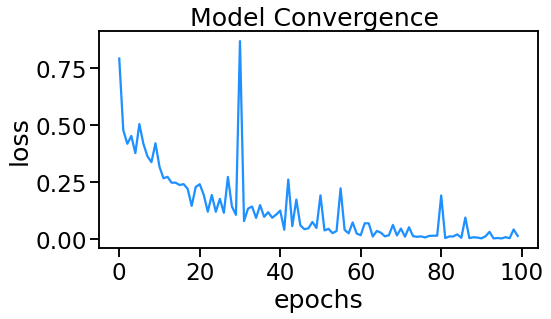

In [21]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr)),train_loss_arr,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.tight_layout()

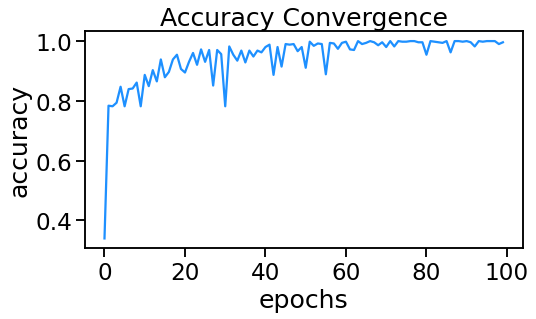

In [22]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr)),train_acc_arr,color='dodgerblue')
plt.title('Accuracy Convergence')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.tight_layout()

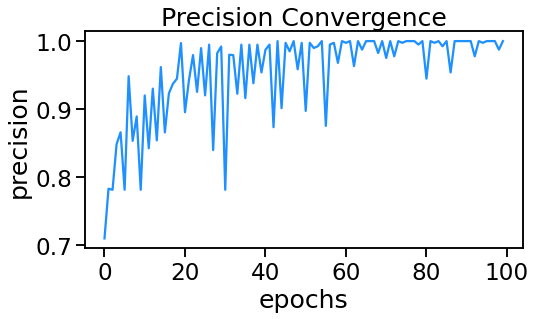

In [23]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr)),train_prec_arr,color='dodgerblue')
plt.title('Precision Convergence')
plt.ylabel('precision')
plt.xlabel('epochs')
plt.tight_layout()

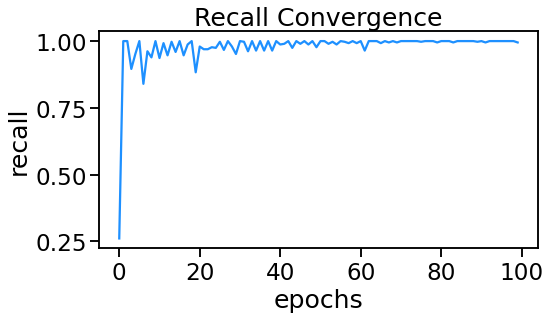

In [24]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr)),train_recall_arr,color='dodgerblue')
plt.title('Recall Convergence')
plt.ylabel('recall')
plt.xlabel('epochs')
plt.tight_layout()

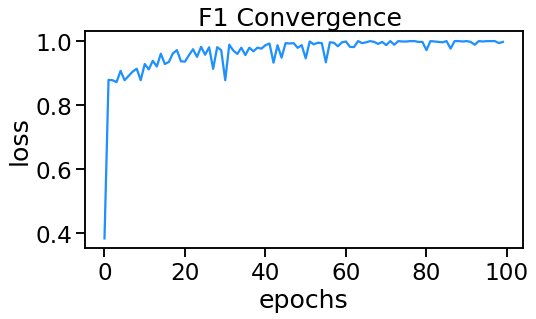

In [25]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr)),train_f1_arr1,color='dodgerblue')
plt.title('F1 Convergence ')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.tight_layout()

In [ ]:
# NUM OF CLIENTS = TOTAL IMAGES / BATCH SIZE
fl_iter = 2
threshold = int(len(train_dataset1) / 10)
train_loss_arr1 = []
train_acc_arr1 = []
train_prec_arr1 = []
train_recall_arr1 = []
train_f1_arr1 = []

print("FL_ITER: ", fl_iter)
print("NUM_CLIENTS_PER_FL_ITER: ", threshold)
print("Batch Idx Size: ", len(client_loader1))


for epoch in range(1, fl_iter + 1):
  global_weights = get_global_weights_from_server()
  local_gradients = []
  net_loss = 0
  net_i = 0
  tn = 0
  fp = 0
  fn = 0
  tp = 0
  count=0
  _accuracy=0
  _precision=0
  _recall=0
  _f1=0

  for fl_client in clients_arr:

    copy_fl_client = copy.deepcopy(fl_client)
    copy_fl_client.set_weights(copy.deepcopy(global_weights))
    local_loss, _tn, _fp, _fn, _tp = copy_fl_client.train_model()
    net_loss += local_loss
    net_i += 1
    tn += _tn
    fp += _fp
    fn += _fn
    tp += _tp
    _accuracy += (_tp+_tn)/(_tp+_fp+_tn+_fn)
    _precision += _tp/(_tp+_fp)
    _recall += _tp/(_tp+_fn)
    _f1 += 2/((1/_recall) + (1/_precision))
    count+=1
    #local_gradients.append(fl_client.get_gradients())
    print("--------Epoch ",epoch,"Client ", net_i,". Local Loss: ", local_loss, ". L-AC: ", _accuracy, ". L-P: ", _precision, ". L-R: ", _recall, ". L-F1: ", _f1)

    if send_local_gradients_to_server(copy_fl_client.get_gradients()) is not True:
            print("Error sending weights to server")
            break
    del copy_fl_client



  loss = net_loss / net_i
  train_loss_arr1.append(loss)
  #accuracy = (tp+tn)/(tp+fp+tn+fn)
  #precision = tp/(tp+fp)
  #recall = tp/(tp+fn)
  #f1 = 2/((1/recall) + (1/precision))
  accuracy=_accuracy/count
  precision=_precision/count
  recall=_recall/count
  f1=2/((1/recall) + (1/precision))
  train_acc_arr1.append(accuracy)
  train_prec_arr1.append(precision)
  train_recall_arr1.append(recall)
  train_f1_arr1.append(f1)

  print("Epoch ", epoch, ". Loss: ", loss, ". Accuracy: ", accuracy, ". Precision: ", precision, ". Recall: ", recall, ". F1-Score: ", f1)